In [1]:
import sys, os
sys.path.append("/Users/zhouji/Documents/github/gempy")
import theano
import pandas as pd
import gempy as gp
import tensorflow as tf
import numpy as np

from gempy.core.tensor.tensorflow_graph import TFGraph

In [2]:
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = "/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model1_orientations.csv",
                        path_i = "/Users/zhouji/Documents/github/gempy/notebooks/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isActive,color,id
0,rock2,Strat_Series,1,True,#015482,1
1,rock1,Strat_Series,2,True,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
# gp.map_series_to_surfaces(geo_data, {"Fault_Series":'fault', 
# #                          "Strat_Series": ('rock2','rock1')})
# geo_data.set_is_fault(['Fault_Series'])

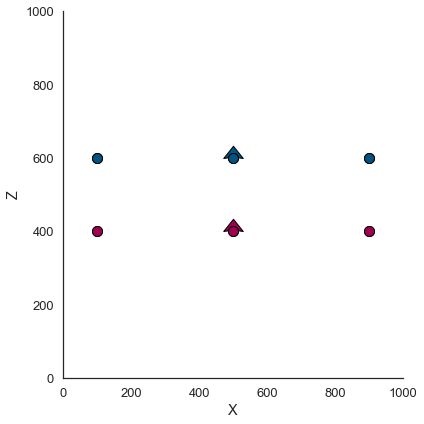

In [5]:
%matplotlib inline
gp.plot.plot_data(geo_data, direction='y')

In [6]:
interpolator = geo_data.interpolator

In [7]:
dips_position = interpolator.orientations.df[['X_r', 'Y_r', 'Z_r']].values
dip_angles = interpolator.orientations.df["dip"].values
azimuth = interpolator.orientations.df["azimuth"].values
polarity = interpolator.orientations.df["polarity"].values

In [8]:
dips_position = interpolator.orientations.df[['X_r', 'Y_r', 'Z_r']].values
dip_angles = interpolator.orientations.df["dip"].values
azimuth = interpolator.orientations.df["azimuth"].values
polarity = interpolator.orientations.df["polarity"].values
surface_points_coord = interpolator.surface_points.df[['X_r', 'Y_r', 'Z_r']].values
grid = interpolator.grid.values_r

In [9]:
interpolator.theano_graph.surface_points_all

All the surface_points points at once

In [10]:
interpolator.theano_graph.input_parameters_kriging


[Position of the dips,
 Angle of every dip,
 Azimuth,
 Polarity,
 All the surface_points points at once,
 Full block matrix for faults or drift. We take 2 times len points for the faultdrift.]

In [11]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,
                                        theano_optimizer='fast_run',
                                 verbose= ['contribution_gradient_interface'])
geo_data.modify_kriging_parameters('drift equations',[9,9])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations   [3, 3]
[9 9]
[9 9] drift equations
              range         $C_o$ drift equations
values  1732.050808  71428.571429          [9, 9]


In [12]:
sol = gp.compute_model(geo_data)

interface_gradient_contribution __str__ = [-0.04119989 -0.04262488 -0.04403718 ... -0.056252   -0.056252
 -0.056252  ]


/Users/zhouji/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=1.54661e-38): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
/Users/zhouji/Documents/github/gempy/gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')


In [13]:
pd.set_option('display.max_columns', 500)

In [14]:
dips_position, dip_angles, azimuth, polarity,surface_points_coord,fault_drift, grid, values_properties = interpolator.get_python_input_block()[0:-3]

In [15]:
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

In [16]:
len_rest_form = interpolator.additional_data.structure_data.df.loc['values','len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc['values', 'rescaling factor']
nugget_effect_grad  = np.cast[dtype](np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](interpolator.surface_points.df['smooth'])

TFG = TFGraph(dips_position, dip_angles, azimuth,
              polarity,surface_points_coord,fault_drift,
              grid, values_properties,len_rest_form,Range,
              C_o,nugget_effect_scalar,nugget_effect_grad,
              rescale_factor)



In [17]:
grid_val= TFG.x_to_interpolate(grid)
weights = TFG.solve_kriging()